# Stock price forecasting system
Authors: Leonardo Emili, Alessio Luciani

## Project setup

In [5]:
try:
    # Setup the project directory if running on Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    !cp gdrive/MyDrive/stock-forecasting-proj/data.zip .
    !unzip -q data.zip
    !rm data.zip
except:
    pass

Mounted at /content/gdrive/


In [6]:
%matplotlib inline

# Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import missingno as msno

# Torch
import torch
import torch.nn as nn

# General
import glob
from tqdm.notebook import tqdm

## Dataset loading

In [466]:
# Key stats dataframe
key_stats_df = pd.read_csv("data/key_stats_yahoo.csv")
key_stats_df.drop(key_stats_df.columns[0], axis=1, inplace=True)

# Prices dataframes for every stock
prices_files = glob.glob("data/prices/*.csv")
dfs_names = [f.rsplit('/', 1)[1][:-len('.csv')] for f in prices_files]
prices_dfs = [pd.read_csv(f) for f in tqdm(prices_files, desc='Reading stock price data', total=len(prices_files))]

## Datasets visualization

In [180]:
print("Key stats dataframe format:")
key_stats_df.head()

Key stats dataframe format:


,Date,Ticker,Price,DE Ratio,Trailing P/E,Price/Sales,Price/Book,Profit Margin,Operating Margin,Return on Assets,Return on Equity,Revenue Per Share,Market Cap,Enterprise Value,Forward P/E,PEG Ratio,Enterprise Value/Revenue,Enterprise Value/EBITDA,Revenue,Gross Profit,EBITDA,Net Income Avl to Common,Diluted EPS,Earnings Growth,Revenue Growth,Total Cash,Total Cash Per Share,Total Debt,Current Ratio,Book Value Per Share,Cash Flow,Beta
0,1/30/2004 19:01,a,33.8320,0.407,NaN,2.80,6.01,29.56,11.97,24.95,47.81,12.803,1.745000e+10,1.652000e+10,25.83,3.84,2.73,NaN,2.73,2.290000e+09,NaN,1.790000e+09,3.774,NaN,0.8,1.610000e+09,3.370,1.150000e+09,2.040,5.930,144000000.0,2.474
1,4/13/2004 4:07,a,28.4626,0.375,NaN,2.43,4.98,25.56,6.20,23.59,46.82,13.160,1.532000e+10,1.477000e+10,20.83,2.89,2.35,NaN,2.35,2.290000e+09,NaN,1.610000e+09,3.391,NaN,0.8,1.680000e+09,3.490,1.150000e+09,2.284,6.394,144000000.0,2.496
2,12/13/2004 21:37,a,21.8816,0.323,33.58,1.61,3.24,4.86,5.38,5.26,10.92,14.610,1.161000e+10,1.037000e+10,15.79,1.62,1.44,15.300,1.44,2.290000e+09,15.300,3.490000e+08,0.710,NaN,0.8,2.320000e+09,4.750,1.150000e+09,2.441,7.320,483000000.0,2.547
3,1/22/2005 5:17,a,20.2478,0.322,30.70,1.52,3.04,4.86,5.38,5.26,10.92,14.610,1.071000e+10,9.760000e+09,14.34,1.51,1.36,14.400,1.36,3.120000e+09,14.400,3.490000e+08,0.710,NaN,18.6,2.320000e+09,4.710,1.150000e+09,2.446,7.329,663000000.0,2.166
4,1/9/2006 2:35,a,31.7118,2.169,52.82,3.31,4.26,6.38,3.58,1.68,3.69,10.403,1.712000e+10,1.487000e+10,NaN,1.81,2.89,35.665,2.89,3.120000e+09,35.665,1.410000e+08,0.660,64.9,22.8,2.250000e+09,4.555,2.169000e+00,2.169,8.095,890000000.0,NaN


In [185]:
print("Prices dataframe format:")
prices_dfs[0].head()

Prices dataframe format:


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,17-12-2009,13.21,13.50,3626300,13.84,13.51,13.51
1,18-12-2009,13.50,13.59,470000,13.69,13.60,13.60
2,21-12-2009,13.50,13.71,230200,13.71,13.60,13.60
3,22-12-2009,13.53,13.59,173100,13.67,13.64,13.64
4,23-12-2009,13.56,13.62,216500,13.69,13.67,13.67


### Utility functions

In [467]:
def prices_df_nan_summary(prices_dfs, names):
    ''' Utility function to summarize columns that have missing values. '''
    result = []
    bins = []
    for i, (prices_df, name) in enumerate(zip(prices_dfs, names)):
        nan_cols = []
        nan_values = []
        for column in prices_df.columns:
            nan_absolute = prices_df[column].isnull().sum()
            if nan_absolute > 0:
                nan_cols.append(column)
                nan_values.append(round(100*nan_absolute/len(prices_df.index), 3))
        if len(nan_cols):
            # It means that either we have all the data for a day or we don't have any data for it
            assert len(set(nan_values)) == 1
            nan_amount = nan_values[0]
            if nan_amount > 0:
                result.append((name, nan_amount))
                bins.append(name)
    return pd.DataFrame(result, columns=['Stock name', 'Missing data (%)'])

def remove_trailing_nan(df: pd.DataFrame, ticker: str, col: str = 'Low') -> pd.DataFrame:
    '''
    A trick to detect if the input DataFrame ends with a contiguous collection of NaN rows.
    It is mainly an adaptation from: https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas
    '''
    if ticker == 'CTQ':
        df.iloc[1397] = np.nan
        df.iloc[1400] = np.nan
    group_by_nan = df[col].isnull().astype(int).groupby(df[col].notnull().astype(int).cumsum()).cumsum()
    training_nans = group_by_nan.iloc[-1]
    #print(group_by_nan)
    return df[:-training_nans]

### Missing values imputation

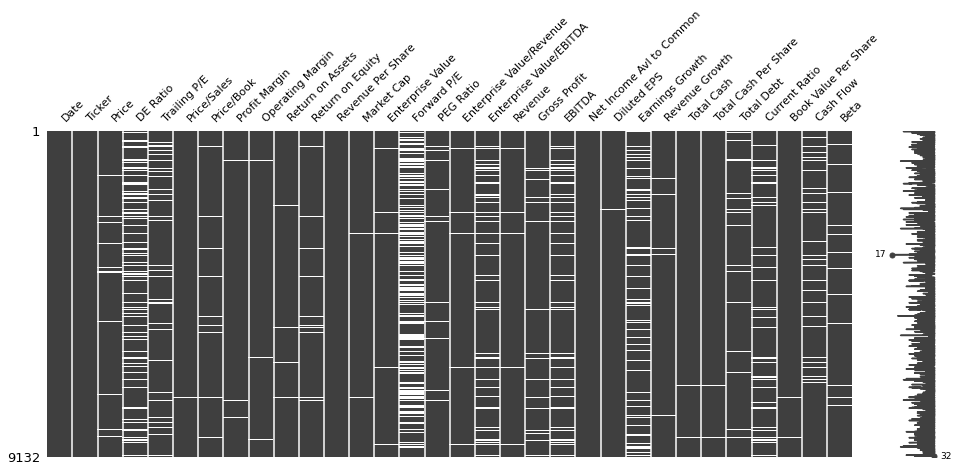

In [468]:
msno.matrix(key_stats_df, figsize=(16,6), fontsize=11)

In [469]:
print("Overview of the missing values in the key_stats dataframe\n")
key_stats_df.isna().sum().sort_values(ascending=False).apply(lambda x: f"{round(100*x/len(key_stats_df.index), 3)}%")

Overview of the missing values in the key_stats dataframe



Forward P/E                  41.251%
DE Ratio                     16.886%
Earnings Growth              15.966%
Enterprise Value/EBITDA      10.633%
EBITDA                        10.37%
Current Ratio                 10.37%
Cash Flow                     9.801%
Trailing P/E                  8.432%
Beta                          4.413%
PEG Ratio                     4.325%
Gross Profit                   3.92%
Total Debt                    3.844%
Price                         3.657%
Return on Equity              3.011%
Return on Assets              2.508%
Price/Book                    2.354%
Revenue Growth                2.146%
Operating Margin              1.391%
Enterprise Value/Revenue      0.942%
Revenue                       0.909%
Total Cash                    0.854%
Enterprise Value              0.723%
Total Cash Per Share          0.712%
Profit Margin                 0.712%
Price/Sales                   0.548%
Book Value Per Share          0.449%
Diluted EPS                   0.296%
M

In [470]:
summary = prices_df_nan_summary(prices_dfs, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', title="Stock price dataset before preprocessing")

In [484]:
prices_dfs_new = [remove_trailing_nan(df,name) for df,name in zip(prices_dfs, dfs_names)]
summary = prices_df_nan_summary(prices_dfs_new, dfs_names)
px.bar(summary, x='Stock name', y='Missing data (%)', title="Stock price dataset after preprocessing")

At this point we use the fast forward imputation technique to fill-in missing values. Please note that in this case missing values are mostly due to holidays or periods when stocks are not exchanged.

In [519]:
prices_dfs_new = [df.fillna(method='ffill') for df in prices_dfs_new]
assert sum([df.Low.isnull().sum() for df in prices_dfs_new]) == 0